**Andere manier om te kijken naar evaluation, i.p.v terug te splitten en te predicten, nu opgeslagen predicition gebruiken**

In [2]:
# Rebuild ID-to-theme mapping directly from the Excel
df_full = pd.read_excel(r"C:\Users\corne\Documents\thesis-question-classification\Data\Grote_data_cleaned.xlsx")
df_full = df_full.dropna(subset=["question"])

label_mapping = df_full[["theme", "theme"]].drop_duplicates()
id_to_theme = dict(zip(label_mapping["theme"], label_mapping["theme"]))


In [3]:
# Recreate label encoding like in training
valid_themes = df_full["theme"].value_counts()[df_full["theme"].value_counts() >= 2].index
df_full = df_full[df_full["theme"].isin(valid_themes)]

unique_themes = list(df_full["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}


In [4]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F

# Load the saved test predictions
df = pd.read_csv(r"C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\GroNLP\Run_2025-04-10_12-18\test_predictions.csv")

# ✅ Recreate logits tensor from the CSV
logits = torch.tensor(df["logits"].apply(eval).tolist())

# ✅ Apply softmax to get prediction probabilities
probabilities = F.softmax(logits, dim=1)

# ✅ Extract raw values
texts = df["text"].tolist()
true_labels_ids = df["true_label"].tolist()
predicted_label_ids = df["predicted_label"].tolist()

# ✅ Recreate theme mapping from cleaned Excel file
df_full = pd.read_excel(r"C:\Users\corne\Documents\thesis-question-classification\Data\Grote_data_cleaned.xlsx")
df_full = df_full.dropna(subset=["question"])
valid_themes = df_full["theme"].value_counts()[df_full["theme"].value_counts() >= 2].index
df_full = df_full[df_full["theme"].isin(valid_themes)]

unique_themes = list(df_full["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}


**Unknowns**

In [5]:
# ✅ Dynamic confidence threshold
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# ✅ Predict with "Unknown" logic
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_id = torch.argmax(probabilities[i]).item()
    question = texts[i]

    if len(question.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")
    else:
        predicted_labels.append(id_to_theme[pred_id])

# ✅ Convert true labels to theme names
true_labels = [id_to_theme[i] for i in true_labels_ids]

# ✅ Compare and mark correctness
results = []
for true, pred in zip(true_labels, predicted_labels):
    if pred == "Unknown":
        results.append("Unknown")
    elif true == pred:
        results.append("Correct")
    else:
        results.append("Incorrect")

# ✅ Build output DataFrame
output_df = pd.DataFrame({
    "Text": texts,
    "True_Theme": true_labels,
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# ✅ Save it
#output_df.to_csv("output/evaluated_predictions.csv", index=False)



Dynamic Threshold: 0.0857


In [6]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 6 / 185 (3.24%)


**Evaluations**

C:\Users\corne\AppData\Local\Temp\ipykernel_17648\1732032154.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


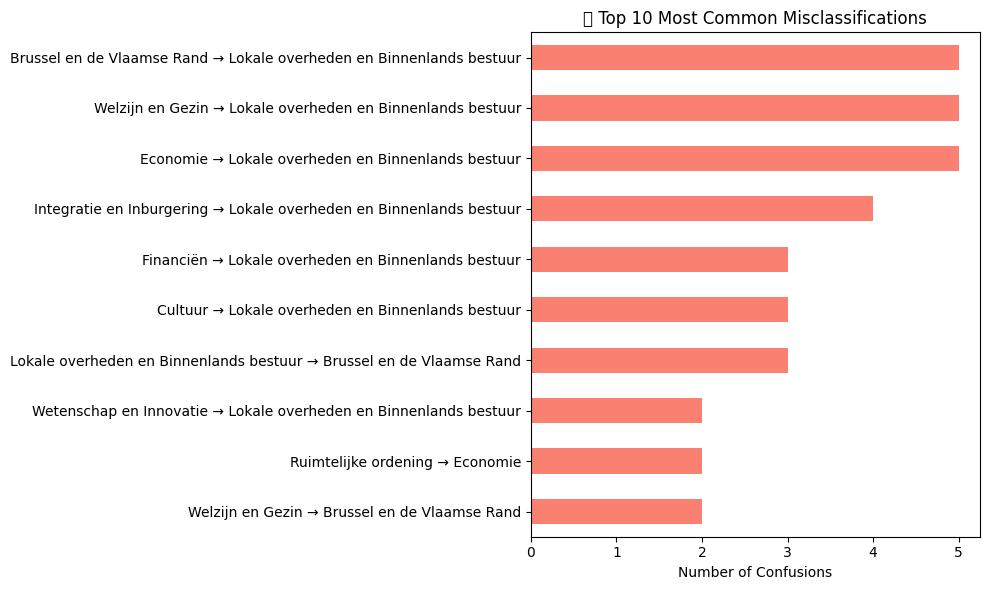

In [7]:
# ✅ Misclassification analysis (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect") &
    (output_df["Predicted_Theme"] != "Unknown")
]

top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

# ✅ Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_confusions_plot.plot(kind="barh", color="salmon")
plt.xlabel("Number of Confusions")
plt.title("🔍 Top 10 Most Common Misclassifications")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

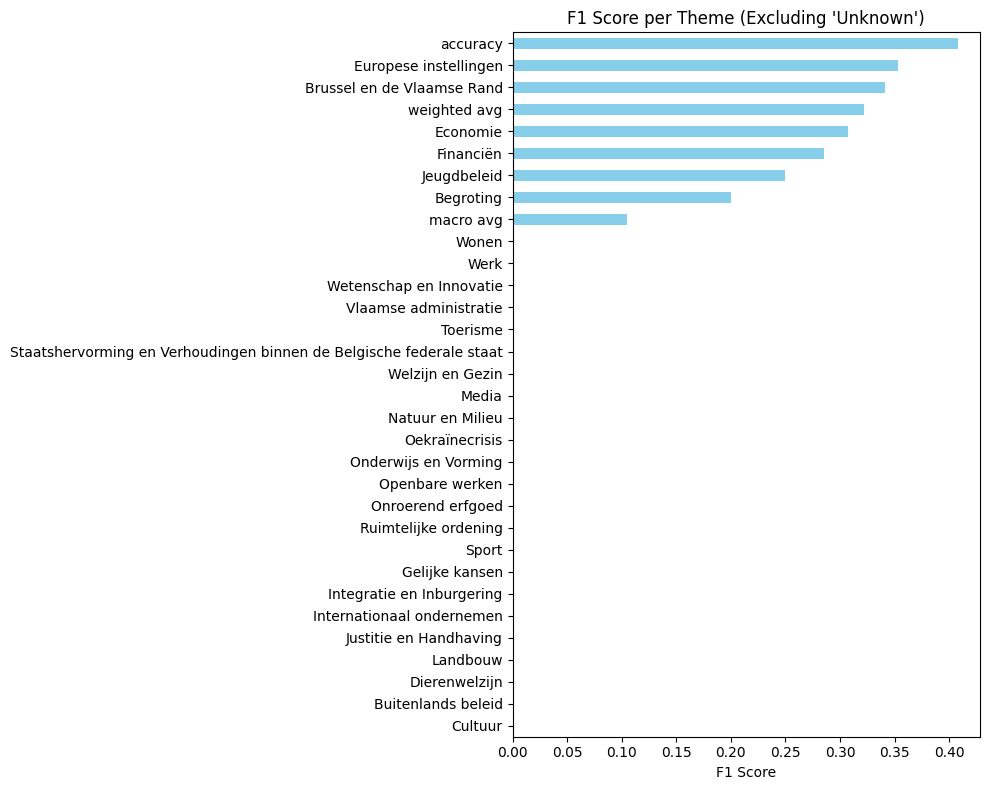

In [8]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Filter out 'Unknown' predictions for proper label matching
filtered_df = output_df[output_df["Predicted_Theme"] != "Unknown"].copy()

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(filtered_df["True_Theme"])
pred_encoded = le.transform(filtered_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme (Excluding 'Unknown')")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()

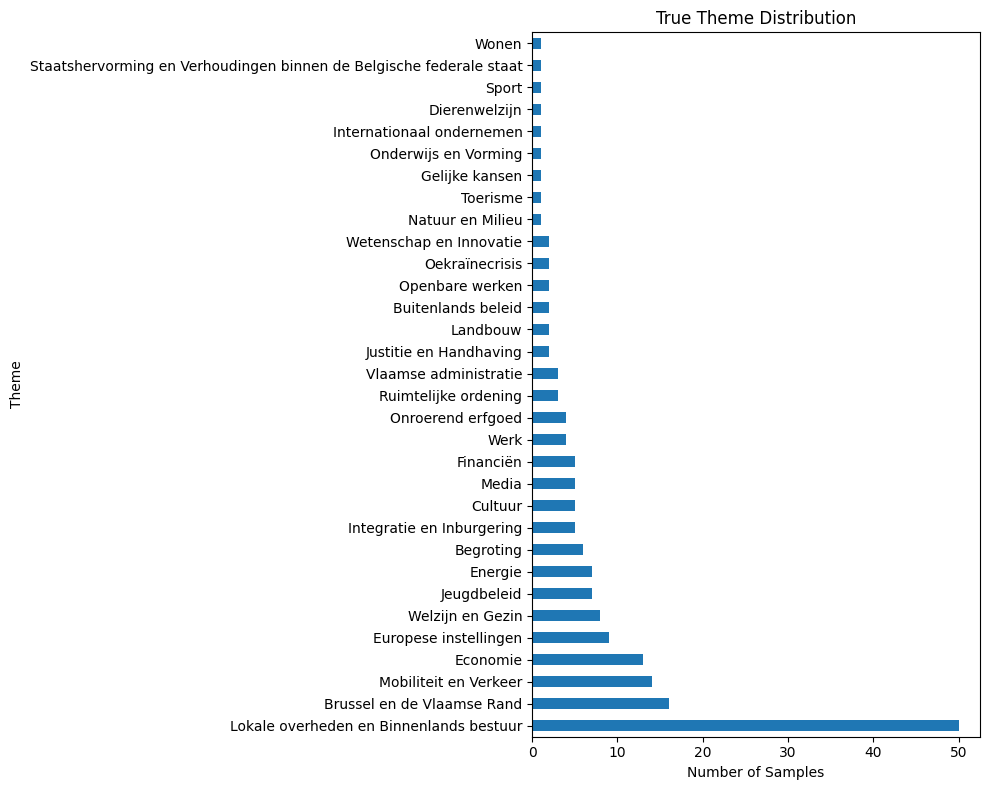

In [9]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import classification_report

# Filter out "Unknown"
filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

# Get all unique themes used
all_labels = sorted(set(filtered_true + filtered_pred))

# ✅ Print classification report using theme names directly
print(classification_report(
    filtered_true,
    filtered_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))


                                                                     precision    recall  f1-score   support

                                                          Begroting       0.25      0.17      0.20         6
                                         Brussel en de Vlaamse Rand       0.28      0.44      0.34        16
                                                 Buitenlands beleid       0.00      0.00      0.00         2
                                                            Cultuur       0.00      0.00      0.00         5
                                                      Dierenwelzijn       0.00      0.00      0.00         1
                                                           Economie       0.29      0.33      0.31        12
                                                            Energie       0.44      0.57      0.50         7
                                              Europese instellingen       0.38      0.33      0.35         9
                  

In [11]:
# ✅ Compute metrics (excluding "Unknown")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
f1 = f1_score(filtered_true, filtered_pred, average="weighted", zero_division=0)

print("\n📊 Evaluation (excluding 'Unknown'):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


📊 Evaluation (excluding 'Unknown'):
Accuracy:  0.4078
Precision: 0.3047
Recall:    0.4078
F1-Score:  0.3216


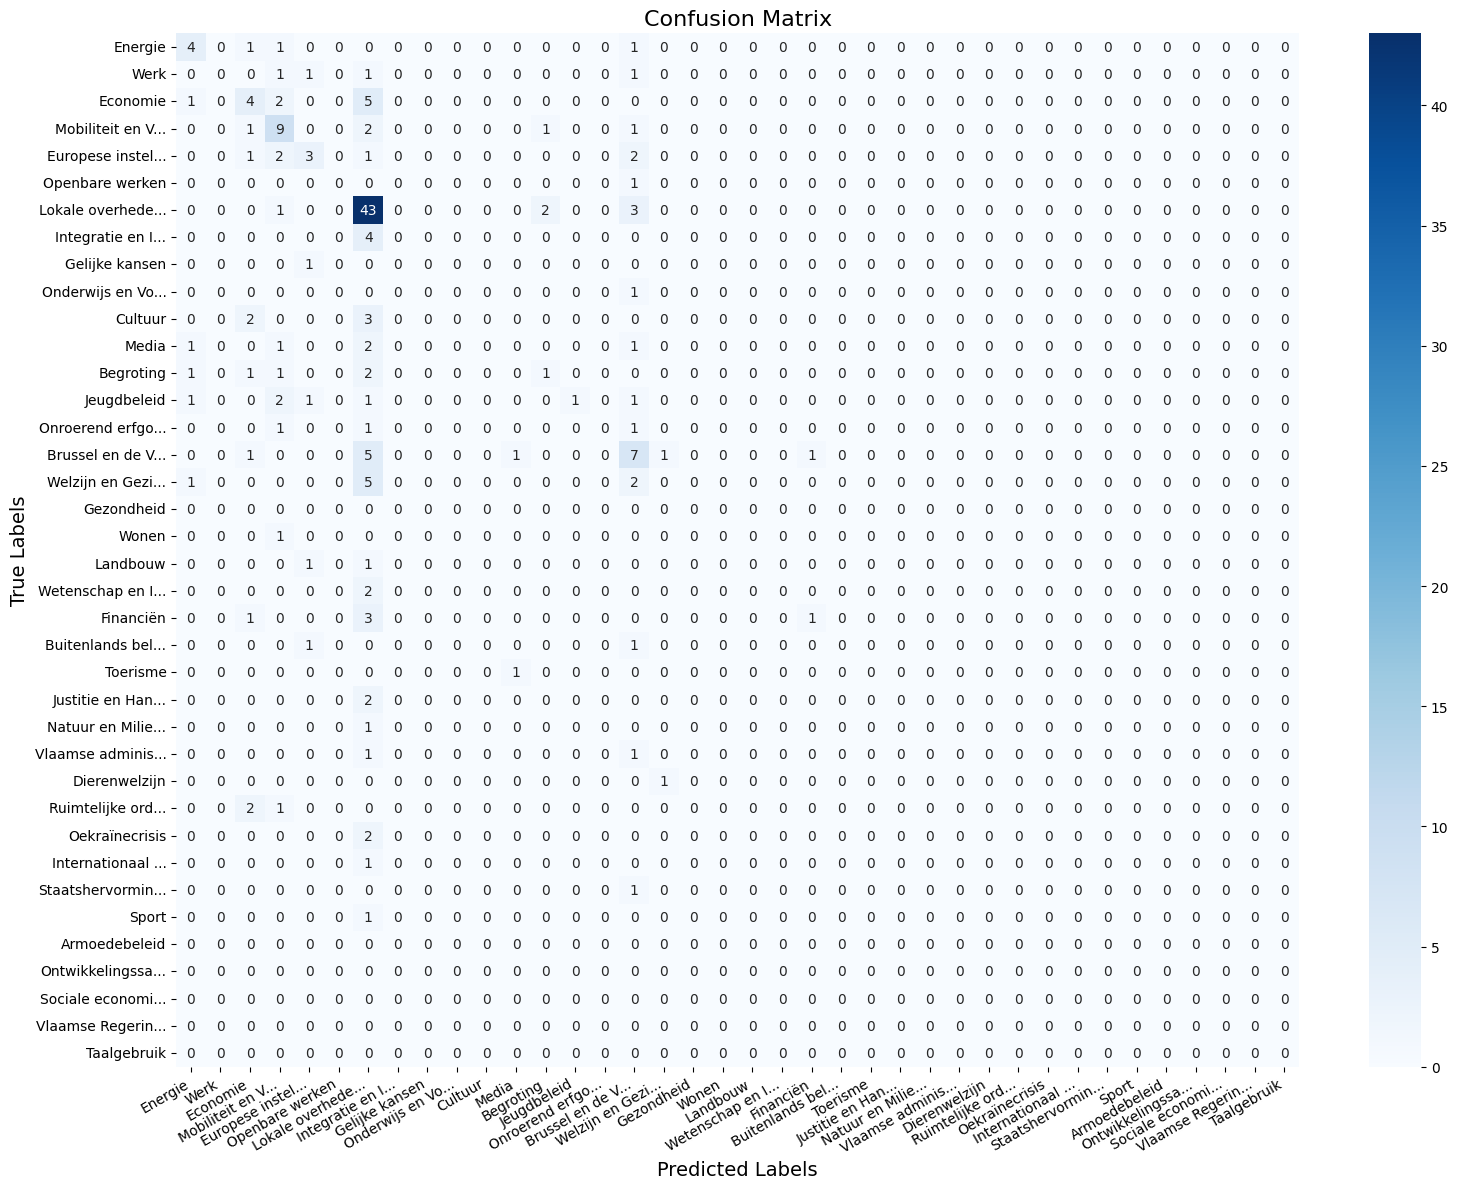

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\mBERT\output\weighted-bert-model"
model_name = "bert-base-multilingual-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name) 
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize and move to device
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    # Extract attention and logits
    attentions = outputs.attentions
    logits = outputs.logits

    # Get predicted class ID and name
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")

    return attentions, predicted_class_id, predicted_class_name


In [17]:
test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Begroting (ID: 12)
🔍 Total Attention Layers Extracted: 12


✅ Weighted ROC AUC: 0.9130


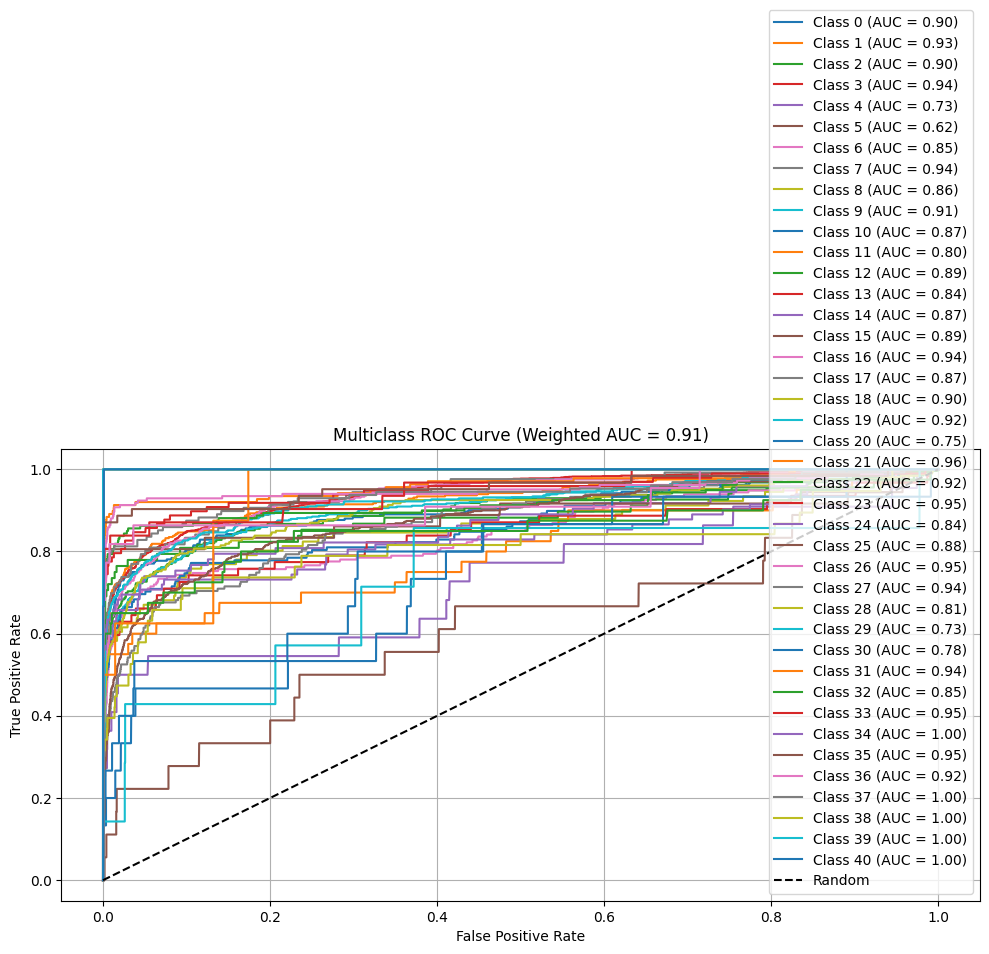

In [19]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load saved predictions
df = pd.read_csv(r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\mBERT\output\test_predictions.csv")

# Reconstruct logits and true labels
logits = np.array(df["logits"].apply(eval).tolist())
y_true = np.array(df["true_label"].tolist())
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute support (number of samples per class)
support = np.bincount(y_true, minlength=n_classes)
total = support.sum()

# Compute weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"✅ Weighted ROC AUC: {weighted_auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Generating fine-tuned embeddings (from test set)...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.44it/s]
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP...


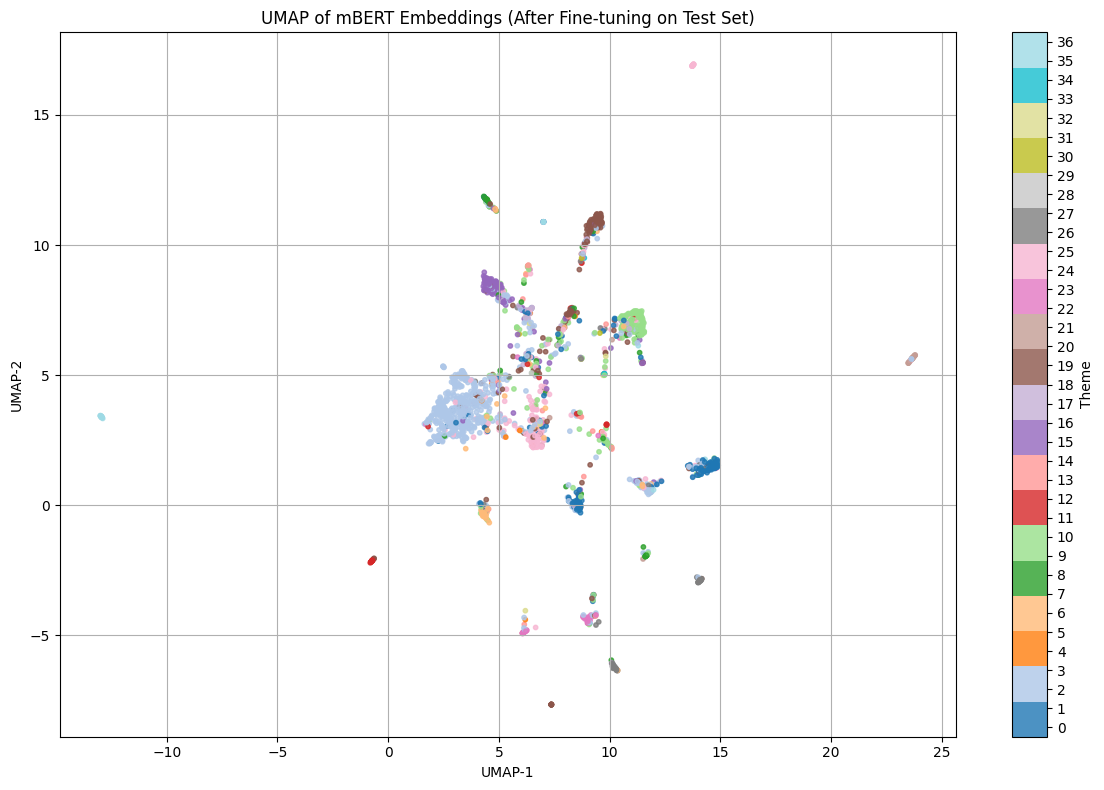

In [22]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# Sample 2000 rows for UMAP
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# Generate embeddings
embeddings = []
print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Encode labels for plotting
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

# Plot UMAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of mBERT Embeddings (After Fine-tuning on Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb = plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
tick_labels = [id_to_theme[i] for i in le.classes_]
cb.ax.set_yticklabels(tick_labels)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()